In [1]:
import h5py
import numpy as np

filename = 'E:/Alibaba German AI Challenge/origin_DATA/training.h5'
f = h5py.File(filename,'r')

s1 = f['sen1']
s2 = f['sen2']
y = f['label']


len(s1)

352366

##### 利用Adam算法优化CNN的demo

In [1]:
# start tensorflow interactiveSession                              
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import random
import h5py

filename = 'E:/Alibaba German AI Challenge/origin_DATA/validation.h5'
f = h5py.File(filename,'r')
print('Get the h5 file')

s1 = np.array(f['sen1'])
s2 = np.array(f['sen2'])
y = np.array(f['label'])

x = []
for i in range(0,s1.shape[0]):
    temp1 = s1[i].flatten()
    temp2 = s2[i].flatten()
    temp = np.hstack((temp1,temp2))
    x.append(temp)
x = np.array(x)

data = np.hstack((x,y))
print('The shape of data is ',data.shape)

sess = tf.InteractiveSession()

#####################################################     Net Define     ##################################################### 

# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Create the model
# placeholder
x = tf.placeholder("float", [None, 18432])
y_ = tf.placeholder("float", [None, 17])


# first convolutinal layer
w_conv1 = weight_variable([5, 5, 18, 32])
b_conv1 = bias_variable([32])

x_image = tf.reshape(x, [-1, 32, 32, 18])

h_conv1 = tf.nn.relu(conv2d(x_image, w_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# second convolutional layer
w_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, w_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# densely connected layer
w_fc1 = weight_variable([8*8*64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

# dropout
keep_prob = tf.placeholder("float")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# readout layer
w_fc2 = weight_variable([1024, 17])
b_fc2 = bias_variable([17])

y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, w_fc2) + b_fc2)

# train and evaluate the model
#交叉熵作为损失函数
delta = 1e-7
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())


#####################################################       Train     ##################################################### 


##随机抽取一部分作为一个mini-batch
def get_batch(data, batch_size):
    sample = random.sample(list(data),batch_size)
    sample = np.array(sample)
    train_x = sample[:,:-17]
    train_y = sample[:,-17:]
    
    return train_x, train_y

Loss = []

batch_size = 200
for i in range(30000):
    batch_x,batch_y = get_batch(data,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5})
    loss_temp = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
    Loss.append(loss_temp)
    if i%200 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        print ("step %d, train accuracy %g" %(i, train_accuracy))
        print('step %d, train loss %f'%(i,loss_temp))
    if loss_temp < 1:
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        print('Final:step %d, train loss %f'%(i,loss_temp))
        print ("Final accuracy %g" %train_accuracy)
        break

#print ("test accuracy %g" % accuracy.eval(feed_dict={x:mnist.test.images, y_:mnist.test.labels, keep_prob:1.0}))

Get the h5 file
The shape of data is  (24119, 18449)
step 0, train accuracy 0.13
step 0, train loss 2227.583252
step 200, train accuracy 0.52
step 200, train loss 566.776917
step 400, train accuracy 0.52
step 400, train loss 457.642822
step 600, train accuracy 0.585
step 600, train loss 313.471619
step 800, train accuracy 0.505
step 800, train loss 326.307465
step 1000, train accuracy 0.57
step 1000, train loss 329.557800
step 1200, train accuracy 0.6
step 1200, train loss 292.324890
step 1400, train accuracy 0.56
step 1400, train loss 285.143494
step 1600, train accuracy 0.61
step 1600, train loss 234.953766
step 1800, train accuracy 0.595
step 1800, train loss 270.195343
step 2000, train accuracy 0.64
step 2000, train loss 286.467865
step 2200, train accuracy 0.645
step 2200, train loss 226.883713
step 2400, train accuracy 0.63
step 2400, train loss 265.833801
step 2600, train accuracy 0.72
step 2600, train loss 252.993439
step 2800, train accuracy 0.69
step 2800, train loss 194.7481

In [2]:
loss_temp = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
loss_temp

0.97654206

In [3]:
vali = np.load('E:/Alibaba German AI Challenge/data_process/sample_of_training.npy')
accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})

0.54720002

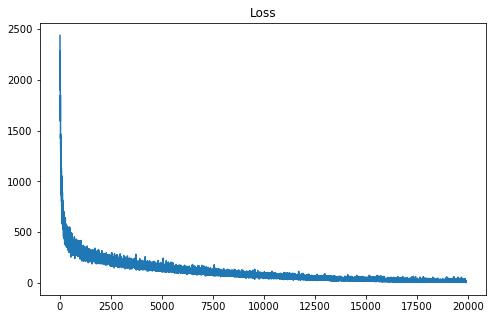

In [2]:
import matplotlib.pyplot as plt

xx = list(range(len(Loss)))

plt.figure(figsize = (8,5))
plt.plot(xx,Loss)
plt.title('Loss')
plt.show()

In [3]:
filename = 'E:/Alibaba German AI Challenge/origin_DATA/round1_test_a_20181109.h5'
f = h5py.File(filename,'r')
test_s1 = f['sen1']
test_s2 = f['sen2']

test = []
for i in range(0,test_s1.shape[0]):
    temp1 = test_s1[i].flatten()
    temp2 = test_s2[i].flatten()
    temp = np.hstack((temp1,temp2))
    test.append(temp)
test = np.array(test)

test_y = np.zeros((test.shape[0],17))

pred = tf.argmax(y_conv, 1)

test_x_0 = test[0:1500]
test_y_0 = test_y[0:1500]
P_0 = pred.eval(feed_dict={x:test_x_0, y_:test_y_0, keep_prob:1.0})

test_x_1 = test[1500:3000]
test_y_1 = test_y[1500:3000]
P_1 = pred.eval(feed_dict={x:test_x_1, y_:test_y_1, keep_prob:1.0})

test_x_2 = test[3000:4500]
test_y_2 = test_y[3000:4500]
P_2 = pred.eval(feed_dict={x:test_x_2, y_:test_y_2, keep_prob:1.0})

test_x_3 = test[4500:]
test_y_3 = test_y[4500:]
P_3 = pred.eval(feed_dict={x:test_x_3, y_:test_y_3, keep_prob:1.0})

P = np.hstack([P_0,P_1,P_2,P_3])

one_hot=tf.one_hot(P,17)
Pred_one_hot = sess.run(one_hot)
Pred_one_hot = Pred_one_hot.astype(np.int32)
out = pd.DataFrame(Pred_one_hot, columns = list(range(17)))
print(out.head())

out.to_csv('second_20k_vali_as_train_Adam.csv', index = False, header = False)

   0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1
1   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0
2   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0
3   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0
4   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0


##### 使用均衡分布的数据进行训练 demo

In [1]:
# start tensorflow interactiveSession                              
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import random

filename = 'E:/Alibaba German AI Challenge/data_process/data.npy'


data = np.load(filename)
print('The shape of data is ',data.shape)

sess = tf.InteractiveSession()

#####################################################     Net Define     ##################################################### 

# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Create the model
# placeholder
x = tf.placeholder("float", [None, 18432])
y_ = tf.placeholder("float", [None, 17])


# first convolutinal layer
w_conv1 = weight_variable([5, 5, 18, 32])
b_conv1 = bias_variable([32])

x_image = tf.reshape(x, [-1, 32, 32, 18])

h_conv1 = tf.nn.relu(conv2d(x_image, w_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# second convolutional layer
w_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, w_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# densely connected layer
w_fc1 = weight_variable([8*8*64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

# dropout
keep_prob = tf.placeholder("float")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# readout layer
w_fc2 = weight_variable([1024, 17])
b_fc2 = bias_variable([17])

y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, w_fc2) + b_fc2)

# train and evaluate the model
#交叉熵作为损失函数
delta = 1e-7
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())


#####################################################       Train     ##################################################### 


##随机抽取一部分作为一个mini-batch
def get_batch(data, batch_size):
    sample = random.sample(list(data),batch_size)
    sample = np.array(sample)
    train_x = sample[:,:-17]
    train_y = sample[:,-17:]
    
    return train_x, train_y

Loss = []

batch_size = 200
for i in range(100000):
    batch_x,batch_y = get_batch(data,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5})
    loss_temp = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
    Loss.append(loss_temp)
    if i%250 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        print ("step %d, train accuracy %g" %(i, train_accuracy))
        print('step %d, train loss %f'%(i,loss_temp))
    if loss_temp < 4:
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        print('Final:step %d, train loss %f'%(i,loss_temp))
        print ("Final accuracy %g" %train_accuracy)
        break

#print ("test accuracy %g" % accuracy.eval(feed_dict={x:mnist.test.images, y_:mnist.test.labels, keep_prob:1.0}))

The shape of data is  (50989, 18449)
step 0, train accuracy 0.095
step 0, train loss 2501.947998
step 250, train accuracy 0.325
step 250, train loss 691.175171
step 500, train accuracy 0.4
step 500, train loss 464.166840
step 750, train accuracy 0.385
step 750, train loss 478.504944
step 1000, train accuracy 0.415
step 1000, train loss 383.896942
step 1250, train accuracy 0.365
step 1250, train loss 419.449768
step 1500, train accuracy 0.425
step 1500, train loss 420.824310
step 1750, train accuracy 0.43
step 1750, train loss 395.652863
step 2000, train accuracy 0.43
step 2000, train loss 363.959473
step 2250, train accuracy 0.42
step 2250, train loss 341.458374
step 2500, train accuracy 0.555
step 2500, train loss 306.630798
step 2750, train accuracy 0.475
step 2750, train loss 323.587952
step 3000, train accuracy 0.48
step 3000, train loss 302.360168
step 3250, train accuracy 0.475
step 3250, train loss 299.143127
step 3500, train accuracy 0.495
step 3500, train loss 300.170990
step 

step 31250, train accuracy 0.84
step 31250, train loss 114.688187
step 31500, train accuracy 0.835
step 31500, train loss 113.541542
step 31750, train accuracy 0.805
step 31750, train loss 141.345490
step 32000, train accuracy 0.86
step 32000, train loss 102.159286
step 32250, train accuracy 0.775
step 32250, train loss 120.237350
step 32500, train accuracy 0.825
step 32500, train loss 100.407204
step 32750, train accuracy 0.825
step 32750, train loss 110.903641
step 33000, train accuracy 0.825
step 33000, train loss 110.227005
step 33250, train accuracy 0.855
step 33250, train loss 101.350990
step 33500, train accuracy 0.825
step 33500, train loss 103.588120
step 33750, train accuracy 0.825
step 33750, train loss 102.337891
step 34000, train accuracy 0.79
step 34000, train loss 119.780388
step 34250, train accuracy 0.855
step 34250, train loss 114.606903
step 34500, train accuracy 0.855
step 34500, train loss 90.204430
step 34750, train accuracy 0.82
step 34750, train loss 125.883163


step 62500, train accuracy 0.98
step 62500, train loss 17.834454
step 62750, train accuracy 0.985
step 62750, train loss 19.469364
step 63000, train accuracy 0.99
step 63000, train loss 13.726264
step 63250, train accuracy 0.985
step 63250, train loss 30.752413
step 63500, train accuracy 0.985
step 63500, train loss 29.016226
step 63750, train accuracy 0.985
step 63750, train loss 17.810101
step 64000, train accuracy 0.99
step 64000, train loss 18.153650
step 64250, train accuracy 0.97
step 64250, train loss 19.629835
step 64500, train accuracy 0.985
step 64500, train loss 23.171654
step 64750, train accuracy 0.99
step 64750, train loss 12.786263
step 65000, train accuracy 0.99
step 65000, train loss 13.052101
step 65250, train accuracy 0.995
step 65250, train loss 14.060141
step 65500, train accuracy 0.985
step 65500, train loss 28.558401
step 65750, train accuracy 0.985
step 65750, train loss 18.265156
step 66000, train accuracy 0.975
step 66000, train loss 24.421934
step 66250, trai

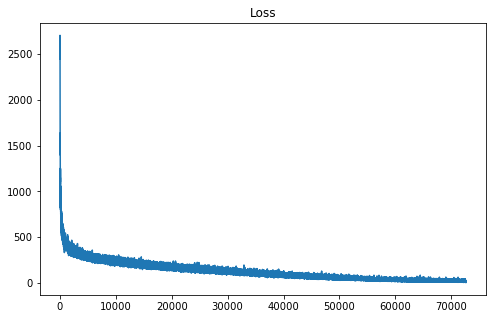

In [2]:
import matplotlib.pyplot as plt

xx = list(range(len(Loss)))

plt.figure(figsize = (8,5))
plt.plot(xx,Loss)
plt.title('Loss')
plt.show()

In [4]:
import h5py
filename = 'E:/Alibaba German AI Challenge/origin_DATA/round1_test_a_20181109.h5'
f = h5py.File(filename,'r')
test_s1 = f['sen1']
test_s2 = f['sen2']

test = []
for i in range(0,test_s1.shape[0]):
    temp1 = test_s1[i].flatten()
    temp2 = test_s2[i].flatten()
    temp = np.hstack((temp1,temp2))
    test.append(temp)
test = np.array(test)

test_y = np.zeros((test.shape[0],17))

pred = tf.argmax(y_conv, 1)

test_x_0 = test[0:1500]
test_y_0 = test_y[0:1500]
P_0 = pred.eval(feed_dict={x:test_x_0, y_:test_y_0, keep_prob:1.0})

test_x_1 = test[1500:3000]
test_y_1 = test_y[1500:3000]
P_1 = pred.eval(feed_dict={x:test_x_1, y_:test_y_1, keep_prob:1.0})

test_x_2 = test[3000:4500]
test_y_2 = test_y[3000:4500]
P_2 = pred.eval(feed_dict={x:test_x_2, y_:test_y_2, keep_prob:1.0})

test_x_3 = test[4500:]
test_y_3 = test_y[4500:]
P_3 = pred.eval(feed_dict={x:test_x_3, y_:test_y_3, keep_prob:1.0})

P = np.hstack([P_0,P_1,P_2,P_3])

one_hot=tf.one_hot(P,17)
Pred_one_hot = sess.run(one_hot)
Pred_one_hot = Pred_one_hot.astype(np.int32)
out = pd.DataFrame(Pred_one_hot, columns = list(range(17)))
print(out.head())

out.to_csv('third_100k_batch_balance_50k_train_Adam.csv', index = False, header = False)

   0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1
1   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0
2   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0
3   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0
4   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0


##### 自制验证集，修改训练loss的阈值，增加模型评估策略，利用综合指标评判模型优劣

In [1]:
# start tensorflow interactiveSession                              
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import random

filename = 'E:/Alibaba German AI Challenge/data_process/data.npy'

vali = np.load('E:/Alibaba German AI Challenge/data_process/sample_of_training_10k.npy')
data = np.load(filename)
print('The shape of data is ',data.shape)

sess = tf.InteractiveSession()

#####################################################     Net Define     ##################################################### 

# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Create the model
# placeholder
x = tf.placeholder("float", [None, 18432])
y_ = tf.placeholder("float", [None, 17])


# first convolutinal layer
w_conv1 = weight_variable([5, 5, 18, 32])
b_conv1 = bias_variable([32])

x_image = tf.reshape(x, [-1, 32, 32, 18])

h_conv1 = tf.nn.relu(conv2d(x_image, w_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# second convolutional layer
w_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, w_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# densely connected layer
w_fc1 = weight_variable([8*8*64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

# dropout
keep_prob = tf.placeholder("float")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# readout layer
w_fc2 = weight_variable([1024, 17])
b_fc2 = bias_variable([17])

y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, w_fc2) + b_fc2)

# train and evaluate the model
#交叉熵作为损失函数
delta = 1e-7
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())


#####################################################       Train     ##################################################### 


##随机抽取一部分作为一个mini-batch
def get_batch(data, batch_size):
    sample = random.sample(list(data),batch_size)
    sample = np.array(sample)
    train_x = sample[:,:-17]
    train_y = sample[:,-17:]
    
    return train_x, train_y

Loss = []
Eval = []

batch_size = 300
for i in range(100000):
    batch_x,batch_y = get_batch(data,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5})
    loss_temp = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
    Loss.append(loss_temp)
    if i%200 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
        Eval.append(train_accuracy)
        print ("step %d, train accuracy %g, train loss %f" %(i, train_accuracy, loss_temp))
#    if loss_temp < 1:
#        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
#        print('Final:step %d, train loss %f'%(i,loss_temp))
#        print ("Final accuracy %g" %train_accuracy)
#        break

#print ("test accuracy %g" % accuracy.eval(feed_dict={x:mnist.test.images, y_:mnist.test.labels, keep_prob:1.0}))

The shape of data is  (50989, 18449)
step 0, train accuracy 0.0422, train loss 3390.677002
step 200, train accuracy 0.3558, train loss 982.563293
step 400, train accuracy 0.3815, train loss 867.350342
step 600, train accuracy 0.396, train loss 696.924622
step 800, train accuracy 0.4006, train loss 710.063599
step 1000, train accuracy 0.4108, train loss 659.363525
step 1200, train accuracy 0.4151, train loss 576.595093
step 1400, train accuracy 0.4363, train loss 600.156067
step 1600, train accuracy 0.4211, train loss 525.058594
step 1800, train accuracy 0.439, train loss 500.896179
step 2000, train accuracy 0.4482, train loss 544.752563
step 2200, train accuracy 0.4521, train loss 500.953247
step 2400, train accuracy 0.4671, train loss 480.814453
step 2600, train accuracy 0.4602, train loss 439.741852
step 2800, train accuracy 0.4787, train loss 434.308746
step 3000, train accuracy 0.4546, train loss 460.352905
step 3200, train accuracy 0.4678, train loss 427.282257
step 3400, train ac

step 29000, train accuracy 0.603, train loss 120.818336
step 29200, train accuracy 0.6036, train loss 113.675385
step 29400, train accuracy 0.6006, train loss 139.493835
step 29600, train accuracy 0.6161, train loss 137.220917
step 29800, train accuracy 0.6053, train loss 125.121140
step 30000, train accuracy 0.5947, train loss 111.375031
step 30200, train accuracy 0.6135, train loss 106.353485
step 30400, train accuracy 0.6182, train loss 141.472260
step 30600, train accuracy 0.6146, train loss 102.579559
step 30800, train accuracy 0.626, train loss 108.193161
step 31000, train accuracy 0.6068, train loss 95.271271
step 31200, train accuracy 0.6094, train loss 115.877884
step 31400, train accuracy 0.6056, train loss 96.853867
step 31600, train accuracy 0.6126, train loss 114.522682
step 31800, train accuracy 0.598, train loss 85.599091
step 32000, train accuracy 0.6214, train loss 88.462448
step 32200, train accuracy 0.6198, train loss 101.369186
step 32400, train accuracy 0.6052, tra

step 58400, train accuracy 0.6332, train loss 7.356300
step 58600, train accuracy 0.6133, train loss 9.851759
step 58800, train accuracy 0.6264, train loss 22.368652
step 59000, train accuracy 0.617, train loss 8.210310
step 59200, train accuracy 0.6258, train loss 5.625319
step 59400, train accuracy 0.6251, train loss 6.540655
step 59600, train accuracy 0.6223, train loss 7.665800
step 59800, train accuracy 0.6171, train loss 4.989734
step 60000, train accuracy 0.6171, train loss 5.729351
step 60200, train accuracy 0.6214, train loss 6.293388
step 60400, train accuracy 0.6226, train loss 36.712982
step 60600, train accuracy 0.6152, train loss 7.444570
step 60800, train accuracy 0.6227, train loss 5.507040
step 61000, train accuracy 0.6311, train loss 3.583932
step 61200, train accuracy 0.6082, train loss 6.544447
step 61400, train accuracy 0.622, train loss 21.588621
step 61600, train accuracy 0.624, train loss 6.277761
step 61800, train accuracy 0.6236, train loss 5.205904
step 62000

step 88200, train accuracy 0.6259, train loss 1.212376
step 88400, train accuracy 0.6086, train loss 1.155725
step 88600, train accuracy 0.6251, train loss 0.634193
step 88800, train accuracy 0.6302, train loss 0.585067
step 89000, train accuracy 0.6191, train loss 0.534900
step 89200, train accuracy 0.6193, train loss 2.006028
step 89400, train accuracy 0.6166, train loss 17.012342
step 89600, train accuracy 0.6111, train loss 17.025372
step 89800, train accuracy 0.6076, train loss 17.229324
step 90000, train accuracy 0.6176, train loss 16.645624
step 90200, train accuracy 0.6186, train loss 0.390142
step 90400, train accuracy 0.631, train loss 17.026569
step 90600, train accuracy 0.6242, train loss 0.912160
step 90800, train accuracy 0.6233, train loss 0.578924
step 91000, train accuracy 0.6193, train loss 0.499168
step 91200, train accuracy 0.6235, train loss 16.840761
step 91400, train accuracy 0.6173, train loss 0.438019
step 91600, train accuracy 0.6176, train loss 0.541330
step 

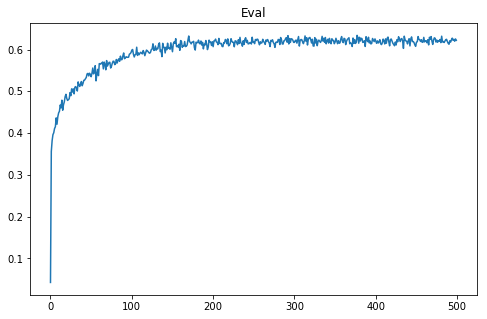

In [2]:
import matplotlib.pyplot as plt

xx = list(range(len(Eval)))

plt.figure(figsize = (8,5))
plt.plot(xx,Eval)
plt.title('Eval')
plt.show()

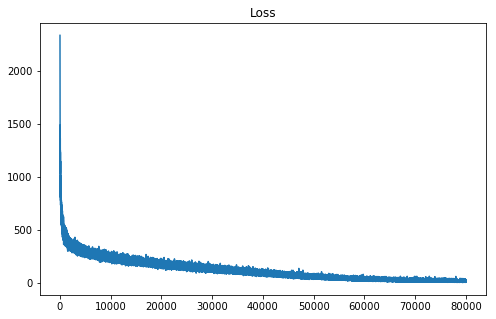

In [2]:
import matplotlib.pyplot as plt

xx = list(range(len(Loss)))

plt.figure(figsize = (8,5))
plt.plot(xx,Loss)
plt.title('Loss')
plt.show()

In [3]:
from sklearn.metrics import classification_report
pred = y_conv.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
train_val_y = np.argmax(vali[:,-17:],axis = 1)
pred_y = np.argmax(pred, axis = 1)
print (classification_report(train_val_y, pred_y))

             precision    recall  f1-score   support

          0       0.30      0.82      0.44       157
          1       0.53      0.45      0.49       710
          2       0.67      0.30      0.42       858
          3       0.36      0.48      0.41       254
          4       0.38      0.48      0.42       492
          5       0.56      0.45      0.50       956
          6       0.34      0.94      0.50        80
          7       0.77      0.43      0.55      1092
          8       0.42      0.58      0.49       389
          9       0.28      0.48      0.35       323
         10       0.92      0.83      0.87      1230
         11       0.35      0.78      0.48       264
         12       0.50      0.81      0.62       268
         13       0.85      0.56      0.68      1186
         14       0.46      1.00      0.63        65
         15       0.55      0.93      0.69       251
         16       0.97      0.98      0.98      1425

avg / total       0.68      0.62      0.63  

In [4]:
import h5py
filename = 'E:/Alibaba German AI Challenge/origin_DATA/round1_test_a_20181109.h5'
f = h5py.File(filename,'r')
test_s1 = f['sen1']
test_s2 = f['sen2']

test = []
for i in range(0,test_s1.shape[0]):
    temp1 = test_s1[i].flatten()
    temp2 = test_s2[i].flatten()
    temp = np.hstack((temp1,temp2))
    test.append(temp)
test = np.array(test)

test_y = np.zeros((test.shape[0],17))

pred = tf.argmax(y_conv, 1)

test_x_0 = test[0:1500]
test_y_0 = test_y[0:1500]
P_0 = pred.eval(feed_dict={x:test_x_0, y_:test_y_0, keep_prob:1.0})

test_x_1 = test[1500:3000]
test_y_1 = test_y[1500:3000]
P_1 = pred.eval(feed_dict={x:test_x_1, y_:test_y_1, keep_prob:1.0})

test_x_2 = test[3000:4500]
test_y_2 = test_y[3000:4500]
P_2 = pred.eval(feed_dict={x:test_x_2, y_:test_y_2, keep_prob:1.0})

test_x_3 = test[4500:]
test_y_3 = test_y[4500:]
P_3 = pred.eval(feed_dict={x:test_x_3, y_:test_y_3, keep_prob:1.0})

P = np.hstack([P_0,P_1,P_2,P_3])

one_hot=tf.one_hot(P,17)
Pred_one_hot = sess.run(one_hot)
Pred_one_hot = Pred_one_hot.astype(np.int32)
out = pd.DataFrame(Pred_one_hot, columns = list(range(17)))
print(out.head())

out.to_csv('forth_100k_batch_balance_50k_train_Adam.csv', index = False, header = False)

   0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1
1   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0
2   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0
3   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0
4   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0


##### 重建CNN，减小感受野，增加网络深度

In [1]:
# start tensorflow interactiveSession                              
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import random

filename = 'E:/Alibaba German AI Challenge/data_process/data.npy'

vali = np.load('E:/Alibaba German AI Challenge/data_process/sample_of_training.npy')
data = np.load(filename)
print('The shape of data is ',data.shape)

sess = tf.InteractiveSession()

#####################################################     Net Define     ##################################################### 

# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Create the model
# placeholder
x = tf.placeholder("float", [None, 18432])
y_ = tf.placeholder("float", [None, 17])


# first convolutinal layer
w_conv1_1 = weight_variable([3, 3, 18, 64])
b_conv1_1 = bias_variable([64])

x_image = tf.reshape(x, [-1, 32, 32, 18])

w_conv1_2 = weight_variable([3, 3, 64, 64])
b_conv1_2 = bias_variable([64])

h_conv1_1 = tf.nn.relu(conv2d(x_image, w_conv1_1) + b_conv1_1)
h_conv1_2 = tf.nn.relu(conv2d(h_conv1_1, w_conv1_2) + b_conv1_2)
h_pool1 = max_pool_2x2(h_conv1_1)

# second convolutional layer
w_conv2_1 = weight_variable([3, 3, 64, 64])
b_conv2_1 = bias_variable([64])

w_conv2_2 = weight_variable([3, 3, 64, 64])
b_conv2_2 = bias_variable([64])

h_conv2_1 = tf.nn.relu(conv2d(h_pool1, w_conv2_1) + b_conv2_1)
h_conv2_2 = tf.nn.relu(conv2d(h_conv2_1, w_conv2_2) + b_conv2_2)
h_pool2 = max_pool_2x2(h_conv2_2)

# densely connected layer
w_fc1 = weight_variable([8*8*64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

# dropout
keep_prob = tf.placeholder("float")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# readout layer
w_fc2 = weight_variable([1024, 17])
b_fc2 = bias_variable([17])

y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, w_fc2) + b_fc2)

# train and evaluate the model
#交叉熵作为损失函数
delta = 1e-7
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())


#####################################################       Train     ##################################################### 


##随机抽取一部分作为一个mini-batch
def get_batch(data, batch_size):
    sample = random.sample(list(data),batch_size)
    sample = np.array(sample)
    train_x = sample[:,:-17]
    train_y = sample[:,-17:]
    
    return train_x, train_y

Loss = []

batch_size = 1000
for i in range(80000):
    batch_x,batch_y = get_batch(data,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5})
    loss_temp = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
    Loss.append(loss_temp)
    if i%250 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        print ("step %d, train accuracy %g, train loss %f" %(i,  train_accuracy, loss_temp))
#    if loss_temp < 1:
#        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
#        print('Final:step %d, train loss %f'%(i,loss_temp))
#        print ("Final accuracy %g" %train_accuracy)
#        break

#print ("test accuracy %g" % accuracy.eval(feed_dict={x:mnist.test.images, y_:mnist.test.labels, keep_prob:1.0}))

KeyboardInterrupt: 